# Vision por Computadoras II - TP (17Co2024)

#### Alumnos
- Adassus, Luciano
- Ignacio Tomas De Pedro Mermier
- Jhonatan Cagua


---

**Objetivo del Proyecto:**

Entrenar un modelo para detectar signos iniciales de incendios forestales, como humo, en imágenes satelitales.

El enfoque está centrado en la **detección temprana**, lo que implica identificar visualmente patrones sutiles que preceden al fuego activo, como la aparición de columnas de humo.

En este proyecto se cuenta con anotaciones en formato **YOLO**, por lo tanto el enfoque adoptado es la **detección de objetos**. Esto significa que el modelo no solo debe identificar si hay humo, sino también **localizarlo espacialmente dentro de la imagen** mediante bounding boxes.

In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
import kagglehub

In [2]:
DATA_DIR = kagglehub.dataset_download("deniszemskikh/wildfire3")

print("Path to dataset files:", DATA_DIR)

100%|██████████| 89.4M/89.4M [00:01<00:00, 91.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/deniszemskikh/wildfire3/versions/1


In [3]:
# Configurar rutas de los datos (ajustarlo según la organización en el Drive)

x_train_dir = os.path.join(DATA_DIR, 'train/images')
y_train_dir = os.path.join(DATA_DIR, 'train/labels')

x_valid_dir = os.path.join(DATA_DIR, 'valid/images')
y_valid_dir = os.path.join(DATA_DIR, 'valid/labels')

x_test_dir = os.path.join(DATA_DIR, 'test/images')
y_test_dir = os.path.join(DATA_DIR, 'test/labels')

## Analisis exploratario de Datos

### 1 - Estructura del dataset

In [4]:
for name, path in {
    "x_train_dir": x_train_dir,
    "y_train_dir": y_train_dir,
    "x_valid_dir": x_valid_dir,
    "y_valid_dir": y_valid_dir,
    "x_test_dir": x_test_dir,
    "y_test_dir": y_test_dir
}.items():
    exists = os.path.exists(path)
    count = len(os.listdir(path)) if exists else 0
    print(f"{name}: {'✅ Existe' if exists else '❌ No existe'} - {count} archivos")

x_train_dir: ✅ Existe - 2620 archivos
y_train_dir: ✅ Existe - 2620 archivos
x_valid_dir: ✅ Existe - 980 archivos
y_valid_dir: ✅ Existe - 980 archivos
x_test_dir: ✅ Existe - 276 archivos
y_test_dir: ✅ Existe - 276 archivos


### 2 - Extraer metainformación de una muestra de imágenes

In [5]:
from PIL import Image
import numpy as np
import pandas as pd

def analyze_images(folder_path, sample_size=500):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))][:sample_size]
    data = []
    for file in image_files:
        try:
            img_path = os.path.join(folder_path, file)
            with Image.open(img_path) as img:
                arr = np.array(img)
                data.append({
                    'filename': file,
                    'format': img.format,
                    'mode': img.mode,
                    'width': img.width,
                    'height': img.height,
                    'mean_pixel_value': arr.mean() if arr.ndim == 3 else np.nan
                })
        except Exception as e:
            data.append({'filename': file, 'error': str(e)})
    return pd.DataFrame(data)

train_df = analyze_images(x_train_dir)
train_df.head()

,filename,format,mode,width,height,mean_pixel_value
0,cal_north2020_250_19_png_jpg.rf.080cc49b732329...,JPEG,RGB,416,416,154.713351
1,Siberia_wildfires_2_-3_jpg.rf.c45b3edd58bcc32b...,JPEG,RGB,640,640,76.941173
2,cal_north2020_246_9_png_jpg.rf.d72da363dec185c...,JPEG,RGB,416,416,87.649237
3,cal_north2021_240_19_png_jpg.rf.9626a0c072dd2c...,JPEG,RGB,416,416,175.657440
4,ETN_snapshot-2004-07-03_jpg.rf.e79937cc4dc7810...,JPEG,RGB,416,416,83.299874


### 3 - Ver distribución de tamaños de imagen y valores de brillo

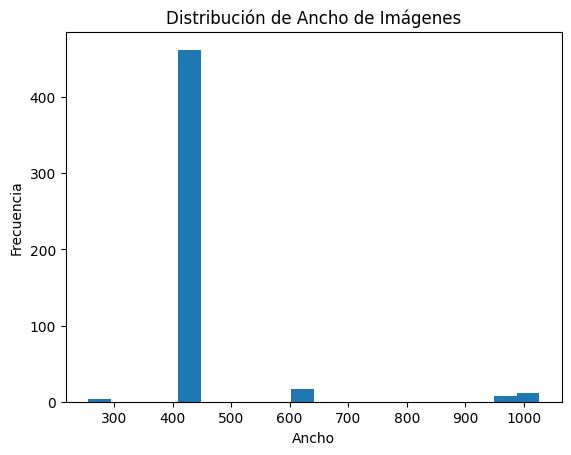

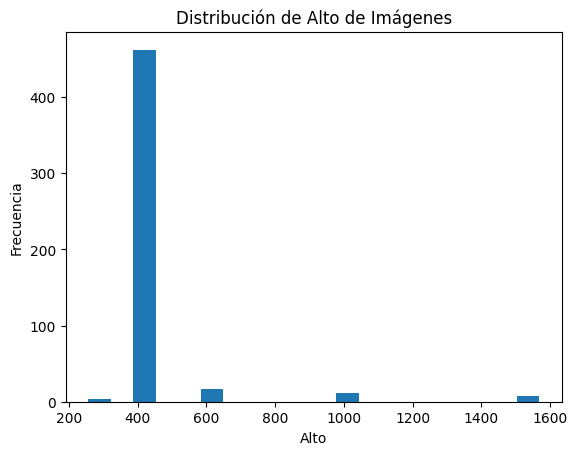

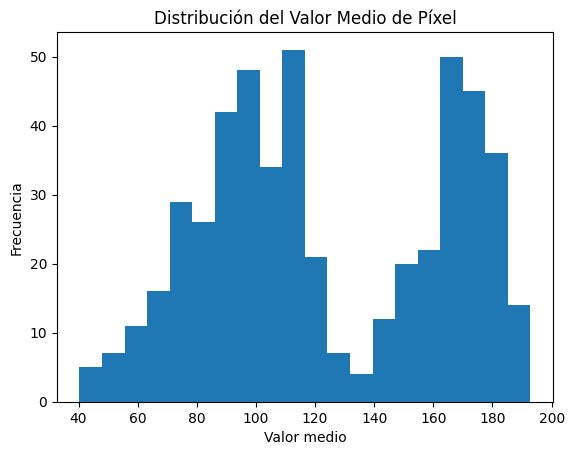

In [14]:
import matplotlib.pyplot as plt

plt.hist(train_df['width'], bins=20)
plt.title("Distribución de Ancho de Imágenes")
plt.xlabel("Ancho")
plt.ylabel("Frecuencia")
plt.show()

print()

# Distribución del alto
plt.hist(train_df['height'], bins=20)
plt.title("Distribución de Alto de Imágenes")
plt.xlabel("Alto")
plt.ylabel("Frecuencia")
plt.show()

print()

plt.hist(train_df['mean_pixel_value'].dropna(), bins=20)
plt.title("Distribución del Valor Medio de Píxel")
plt.xlabel("Valor medio")
plt.ylabel("Frecuencia")
plt.show()

**Conclusiones:**
- La **mayoría de las imágenes tienen un ancho estándar de ~416 píxeles**, lo que indica una fuente homogénea de datos.
- El **alto de las imágenes también está dominado por el valor de 416 píxeles**, confirmando que el dataset está mayormente compuesto por imágenes cuadradas de 416×416.
- Existen algunos **outliers** con dimensiones mayores (ej. 640, 1024, 1536), pero son minoría.
- Esto sugiere que se puede trabajar con un tamaño de entrada fijo de 416×416, ya que coincide con la resolución predominante.
- La **distribución del valor medio de píxel** muestra una forma **bimodal o multimodal**:
  - Imágenes más oscuras (valor medio entre 50–100) → posiblemente contienen humo o fuego.
  - Imágenes más claras (valor medio entre 160–180) → podrían corresponder a cielos despejados o áreas sin incendio.

### 4 - Distribución de cantidad de objetos por imagen

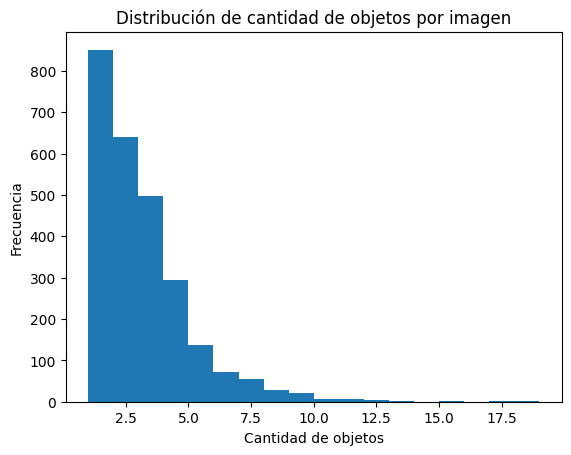

In [7]:
label_counts = []
for fname in os.listdir(y_train_dir):
    if fname.endswith(".txt"):
        with open(os.path.join(y_train_dir, fname)) as f:
            label_counts.append(len(f.readlines()))

plt.hist(label_counts, bins=range(1, max(label_counts)+2))
plt.title("Distribución de cantidad de objetos por imagen")
plt.xlabel("Cantidad de objetos")
plt.ylabel("Frecuencia")
plt.show()

**Conslusiones:**
- La mayoría de las imágenes tienen entre **1 y 5 objetos** etiquetados.
- Son pocos los casos con más de 10 objetos por imagen.
- Esto sugiere una anotación precisa y controlada, ideal para entrenamiento.

### 5 - Mostrar algunas imágenes al azar

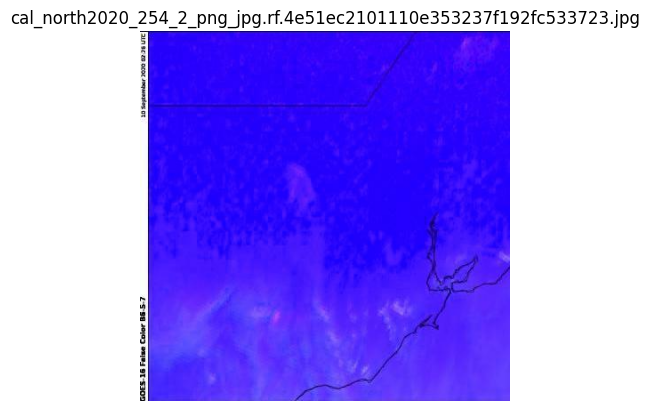

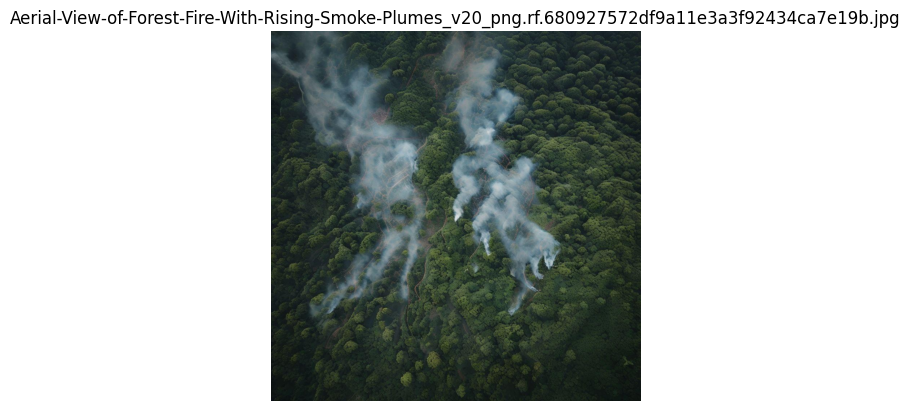

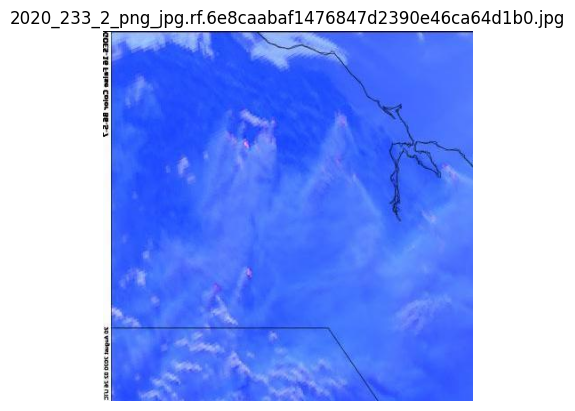

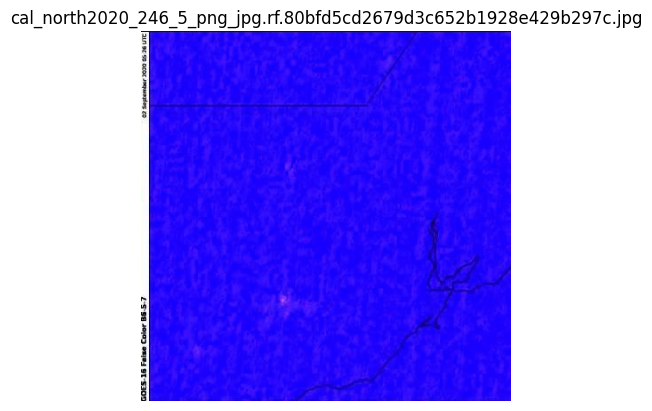

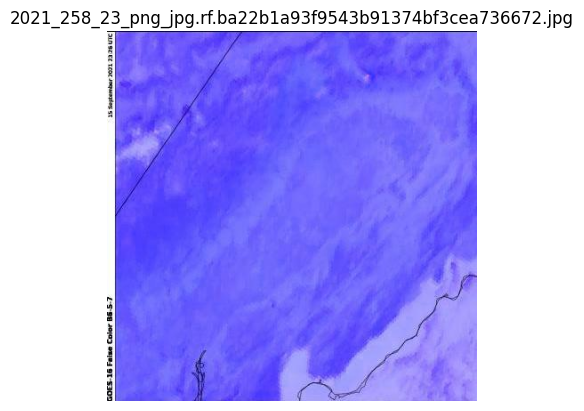

In [8]:
import random

sample_images = random.sample(list(train_df['filename']), 5)
for img_name in sample_images:
    img = Image.open(os.path.join(x_train_dir, img_name))
    plt.imshow(img)
    plt.title(img_name)
    plt.axis('off')
    plt.show()

### 6 - Revisar duplicados y validar nombres pareados

In [9]:
duplicates = train_df['filename'].duplicated().sum()
print(f"Imágenes duplicadas por nombre: {duplicates}")

# Validar nombres pareados
image_files = sorted([f.split('.')[0] for f in os.listdir(x_train_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
label_files = sorted([f.split('.')[0] for f in os.listdir(y_train_dir) if f.endswith('.txt')])

missing_labels = set(image_files) - set(label_files)
missing_images = set(label_files) - set(image_files)

print(f"Imágenes sin etiqueta: {len(missing_labels)}")
print(f"Etiquetas sin imagen: {len(missing_images)}")

Imágenes duplicadas por nombre: 0
Imágenes sin etiqueta: 0
Etiquetas sin imagen: 0


### 7 - Revisar proporciones

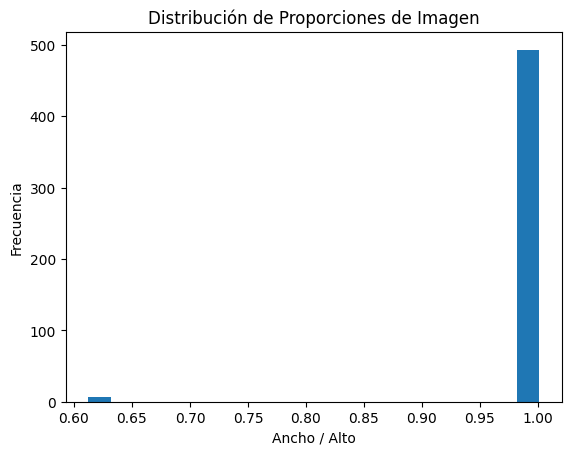

In [10]:
train_df['aspect_ratio'] = train_df['width'] / train_df['height']
plt.hist(train_df['aspect_ratio'], bins=20)
plt.title("Distribución de Proporciones de Imagen")
plt.xlabel("Ancho / Alto")
plt.ylabel("Frecuencia")
plt.show()

**Conclusiónes:**
- Casi todas las imágenes tienen proporción ≈ 1.0 → esto indica que son cuadradas.
- Hay un pequeñísimo grupo con proporción ≈ 0.6, lo cual podría representar:
  - Algunas imágenes rectangulares verticales.
  - Las imágenes quizás sean ruido, mal procesadas o de otra fuente.

### 8 - Visualización de múltiples imágenes con sus etiquetas (bounding boxes)

Se genera un mosaico con varias imágenes del conjunto de entrenamiento.  
Cada imagen se carga junto con su archivo de etiquetas (laberls) en formato YOLO, y se dibujan las bounding boxes correspondientes.

Esto permite inspeccionar visualmente la calidad y consistencia de las anotaciones, así como observar cómo se representa el humo u otros elementos relevantes en los datos.


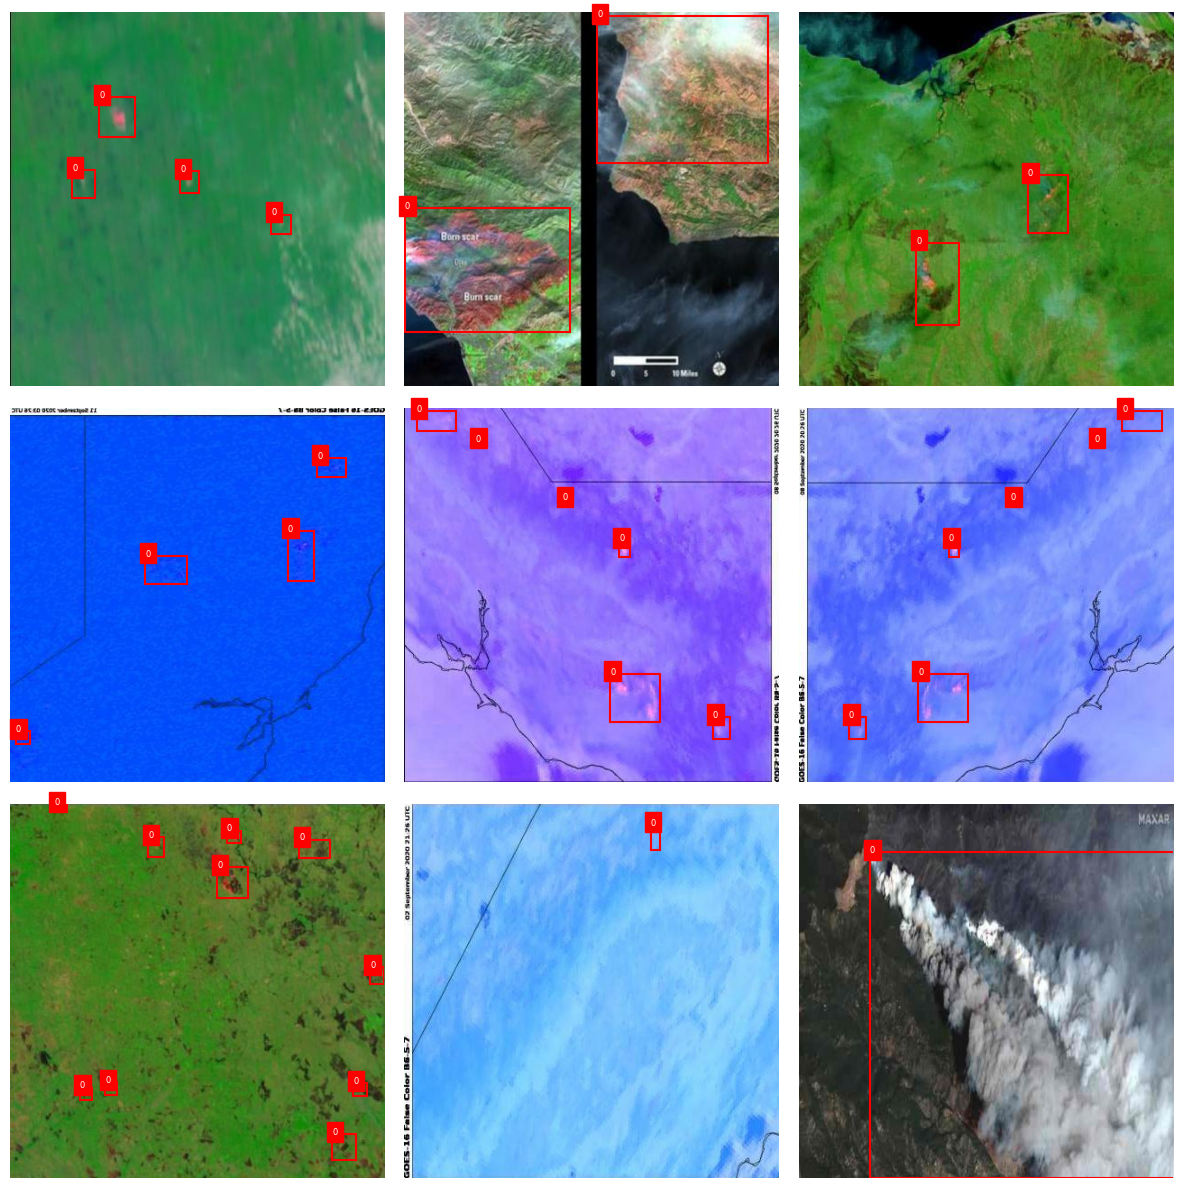

In [11]:
import matplotlib.patches as patches

def draw_yolo_boxes(image_path, label_path, ax=None):
    with Image.open(image_path) as img:
        if ax is None:
            fig, ax = plt.subplots(1)
        ax.imshow(img)
        w, h = img.size

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    cls, x_center, y_center, bw, bh = map(float, line.strip().split())
                    x = (x_center - bw/2) * w
                    y = (y_center - bh/2) * h
                    width = bw * w
                    height = bh * h
                    rect = patches.Rectangle((x, y), width, height, linewidth=1.5, edgecolor='r', facecolor='none')
                    ax.add_patch(rect)
                    ax.text(x, y, f"{int(cls)}", color='white', fontsize=6, backgroundcolor='red')
        ax.axis('off')

# Mosaico de 9 imágenes con sus cajas
sample_imgs = random.sample(train_df['filename'].tolist(), 9)
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for img_name, ax in zip(sample_imgs, axes.flatten()):
    img_path = os.path.join(x_train_dir, img_name)
    label_path = os.path.join(y_train_dir, os.path.splitext(img_name)[0] + '.txt')
    draw_yolo_boxes(img_path, label_path, ax=ax)
plt.tight_layout()
plt.show()

### 9 - Distribución del área relativa de las bounding boxes

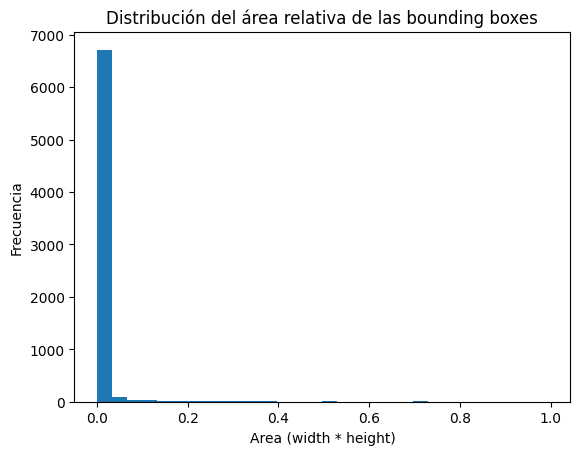

In [12]:
areas = []
for fname in os.listdir(y_train_dir):
    if fname.endswith(".txt"):
        with open(os.path.join(y_train_dir, fname)) as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    _, _, _, w, h = map(float, parts)
                    areas.append(w * h)

plt.hist(areas, bins=30)
plt.title("Distribución del área relativa de las bounding boxes")
plt.xlabel("Area (width * height)")
plt.ylabel("Frecuencia")
plt.show()

**Conclusiones:**
- La gran mayoría de las cajas tienen un área **muy pequeña** en relación con la imagen total.
- Esto indica que el humo detectado suele ocupar zonas localizadas y no extensas.
- Algunas pocas cajas grandes podrían representar incendios más visibles o humo muy denso.

### 10 - Conclusión del Análisis Exploratorio (EDA)

**🔍 Conclusiones del EDA:**
- El dataset está bien estructurado y dividido en `train`, `val` y `test`.
- Las imágenes tienen tamaños y proporciones bastante consistentes (predominan imágenes cuadradas).
- Las etiquetas están en formato YOLO con bounding boxes, enfocadas en la detección de humo.
- La mayoría de las imágenes tienen entre 1 y 5 objetos etiquetados.
- Las cajas son en su mayoría pequeñas, lo que indica que el modelo deberá detectar objetos de tamaño reducido.

---

**🛠 Próximos pasos sugeridos:**

1. **Preprocesamiento**:
   - Redimensionar imágenes a un tamaño fijo (ej. 416x416).
   - Normalizar valores de píxel.
   - Filtrar outliers si se desea (imágenes muy distintas en tamaño o proporción).

2. **Aumento de datos (data augmentation)**:
   - Rotaciones, flips, cambios de brillo o contraste para robustecer el modelo frente a variaciones.

3. **Entrenamiento del modelo**:
   - Usar un modelo de detección como YOLOv5/v8 con las anotaciones ya existentes.
   - Monitorear métricas como `mAP`, `recall`, `precision` durante validación.

4. **Evaluación y mejora**:
   - Ver ejemplos de falsas detecciones.
   - Ajustar umbrales de confianza o refinar etiquetas si es necesario.

---

**🚀 Técnicas avanzadas aplicables (futuras extensiones)**

- **GradCAM**: para visualizar qué zonas de la imagen son utilizadas por el modelo para tomar decisiones. Útil para validar que el modelo realmente detecta humo.
- **Visual Transformers (ViT, DETR)**: alternativas modernas a YOLO, con atención global y potencial para mejor rendimiento en detección.
- **GANs**: generación de imágenes sintéticas de humo para enriquecer el dataset si se requiere mayor variedad visual.
- **Aprendizaje no supervisado**: para explorar agrupamientos naturales de imágenes o detectar outliers.
- **Segmentación semántica**: si se dispone de máscaras detalladas, permite predecir con mayor precisión la extensión del humo.